## **Importing modules**

In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from PIL import Image
import glob
import concurrent.futures
from tqdm import tqdm

In [4]:
from sklearn.manifold import TSNE
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

In [5]:
# Set the dataset path
DATASET_PATH = "/kaggle/input/plantdisease/PlantVillage" 

In [6]:
# Ensure the dataset path exists
if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"Dataset folder not found at {DATASET_PATH}")

In [7]:
# Get all class names (subdirectories)
class_names = sorted([d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))])

# Dictionary to store class image count
class_counts = {class_name: len(os.listdir(os.path.join(DATASET_PATH, class_name))) for class_name in class_names}

# Convert to DataFrame for visualization
df_class_dist = pd.DataFrame(list(class_counts.items()), columns=["Class", "Image Count"])

In [8]:
df_class_dist.head()

Class  Image Count
0  Pepper__bell___Bacterial_spot          997
1         Pepper__bell___healthy         1478
2          Potato___Early_blight         1000
3           Potato___Late_blight         1000
4               Potato___healthy          152

### **Data Visualization for analayzing imbalance**

The dataset includes various plant species such as pepper, potato, and tomato, with different conditions like bacterial spots, blights, leaf mold, and viral infections. The horizontal bar chart illustrates the count of images per class, indicating an imbalance in the dataset, with some classes having significantly more samples than others. For instance, "Tomato__Tomato_YellowLeaf_Curl_Virus" has the highest number of images, while "Potato___healthy" has one of the lowest. Such distributions are crucial for understanding dataset biases and guiding model training strategies to ensure balanced performance across all categories.

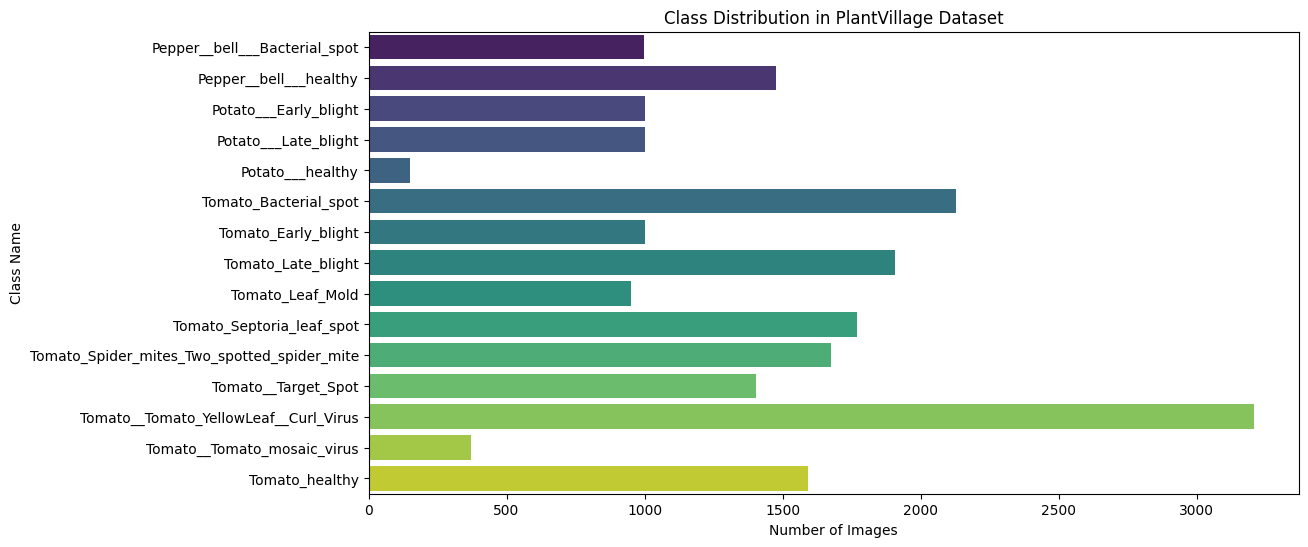

In [9]:
plt.figure(figsize=(12, 6))
sns.barplot(x="Image Count", y="Class", data=df_class_dist, palette="viridis")
plt.xlabel("Number of Images")
plt.ylabel("Class Name")
plt.title("Class Distribution in PlantVillage Dataset")
plt.show()

In [10]:
def analyze_class_distribution():
    """
    Computes and visualizes the percentage of images per class in the dataset.
    
    Returns:
    - Displays a bar chart of class distribution
    """
    class_counts = {}  # Dictionary to store class-wise image counts

    total_images = 0  # To calculate percentage
    for class_name in class_names:
        class_path = os.path.join(DATASET_PATH, class_name)
        img_files = glob.glob(os.path.join(class_path, "*.*"))  # Load all image files
        img_files = [f for f in img_files if f.lower().endswith((".jpg", ".jpeg", ".png"))] 
        
        count = len(img_files)  # Count images in the class
        class_counts[class_name] = count
        total_images += count  # Update total count

    # Convert counts to percentages
    class_percentages = {cls: (count / total_images) * 100 for cls, count in class_counts.items()}

    # Sort classes by percentage
    sorted_classes = sorted(class_percentages.items(), key=lambda x: x[1], reverse=True)

    # Plot class distribution
    plt.figure(figsize=(10, 6))
    plt.barh([x[0] for x in sorted_classes], [x[1] for x in sorted_classes], color='skyblue')
    plt.xlabel("Percentage of Images")
    plt.ylabel("Class Name")
    plt.title("Class Distribution (Percentage of Images per Class)")
    plt.gca().invert_yaxis()  # Invert y-axis for better visualization
    plt.grid(axis="x", linestyle="--", alpha=0.6)

    # Display class percentages
    for i, (class_name, percent) in enumerate(sorted_classes):
        plt.text(percent + 0.5, i, f"{percent:.2f}%", va="center", fontsize=10)

    plt.show()

    # Print underrepresented classes (less than 5% of dataset)
    underrepresented = [cls for cls, percent in class_percentages.items() if percent < 5]
    print("Underrepresented Classes (<5% of total images):", underrepresented)


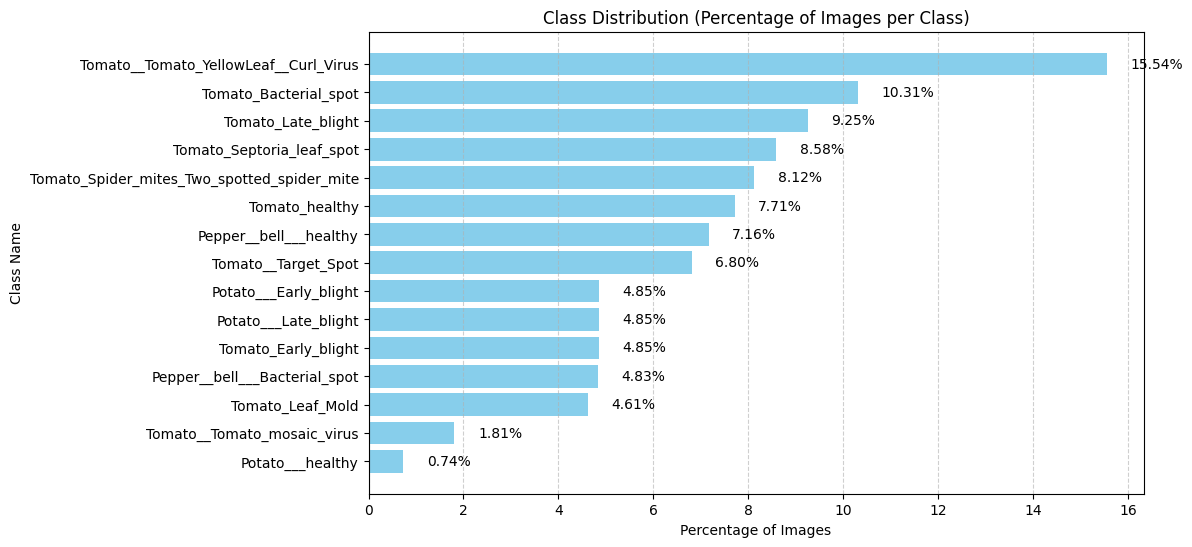

Underrepresented Classes (<5% of total images): ['Pepper__bell___Bacterial_spot', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Early_blight', 'Tomato_Leaf_Mold', 'Tomato__Tomato_mosaic_virus']


In [11]:
analyze_class_distribution()

### **Check for Image Quality**

In [12]:
corrupt_images = []
image_shapes = []

In [13]:
def check_image(img_path):
    """Checks if an image is corrupt and extracts its dimensions."""
    try:
        with Image.open(img_path) as img:
            img.load()  # Efficiently loads image without needing `verify()`
            return img.size  # Return dimensions if valid
    except Exception:
        return "corrupt"

In [14]:
# List all image paths
image_paths = []
for class_name in class_names:
    class_path = os.path.join(DATASET_PATH, class_name)
    image_paths.extend([os.path.join(class_path, img_name) for img_name in os.listdir(class_path)])

# Use ThreadPoolExecutor for parallel processing
with concurrent.futures.ThreadPoolExecutor() as executor:
    results = list(tqdm(executor.map(check_image, image_paths), total=len(image_paths)))

# Process results
for img_path, result in zip(image_paths, results):
    if result == "corrupt":
        corrupt_images.append(img_path)
    else:
        image_shapes.append(result)

100%|██████████| 20639/20639 [00:24<00:00, 834.41it/s]


In [15]:

# Print corrupt images
if corrupt_images:
    print(f"Found {len(corrupt_images)} corrupt images. Consider removing them.")
else:
    print("No corrupt images found!")

Found 1 corrupt images. Consider removing them.


In [16]:
print(corrupt_images)

['/kaggle/input/plantdisease/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/svn-r6Yb5c']


### **Visualizing Image sizes**

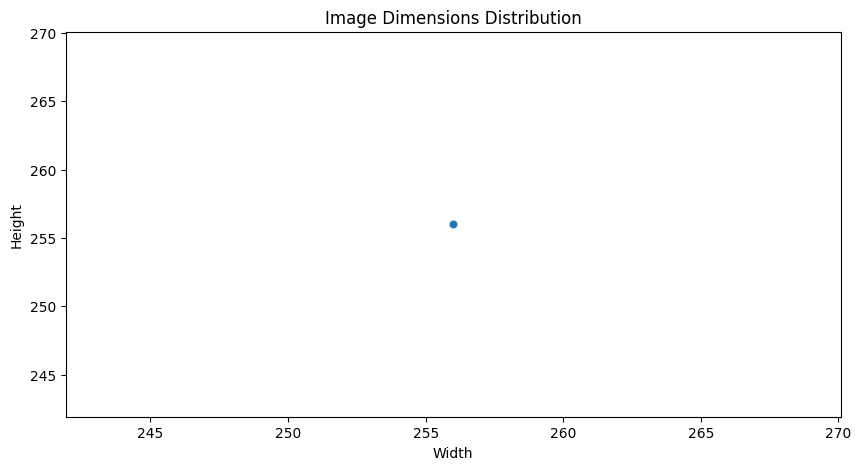

In [17]:
image_shapes_df = pd.DataFrame(image_shapes, columns=["Width", "Height"])
plt.figure(figsize=(10, 5))
sns.scatterplot(x=image_shapes_df["Width"], y=image_shapes_df["Height"], alpha=0.5)
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Image Dimensions Distribution")
plt.show()

In [18]:
print("Height of all the images: ",image_shapes_df.iloc[0,0])
print("Width of all the images: ", image_shapes_df.iloc[0,1])

Height of all the images:  256
Width of all the images:  256


**Note**: All the images have the same height and width.

### **Visualization of images from different classes**

In [19]:
def show_sample_images(num_samples=5):
    """Displays sample images from each class with class labels."""
    
    num_classes = len(class_names)  # Total number of classes
    fig, axes = plt.subplots(num_classes, num_samples, figsize=(num_samples * 3, num_classes * 2))
    
    if num_classes == 1:
        axes = [axes]  # Ensure axes is iterable for a single class
    
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(DATASET_PATH, class_name)
        img_files = glob.glob(os.path.join(class_path, "*"))[:num_samples]  # Get image paths

        for j in range(num_samples):
            ax = axes[i, j] if num_classes > 1 else axes[j]  # Handle 1-row case
            
            if j < len(img_files):  
                img = Image.open(img_files[j])
                ax.imshow(img)
               
                ax.set_title(class_name.replace("__"," ").replace("_"," "))  # Display image filename
            else:
                ax.set_xticks([])  # Hide empty subplots
                ax.set_yticks([])

            ax.axis("off")  # Remove axes
            
        axes[i, 0].set_ylabel(class_name, fontsize=10)  # Set class label
    
    
    plt.tight_layout()
    plt.show()

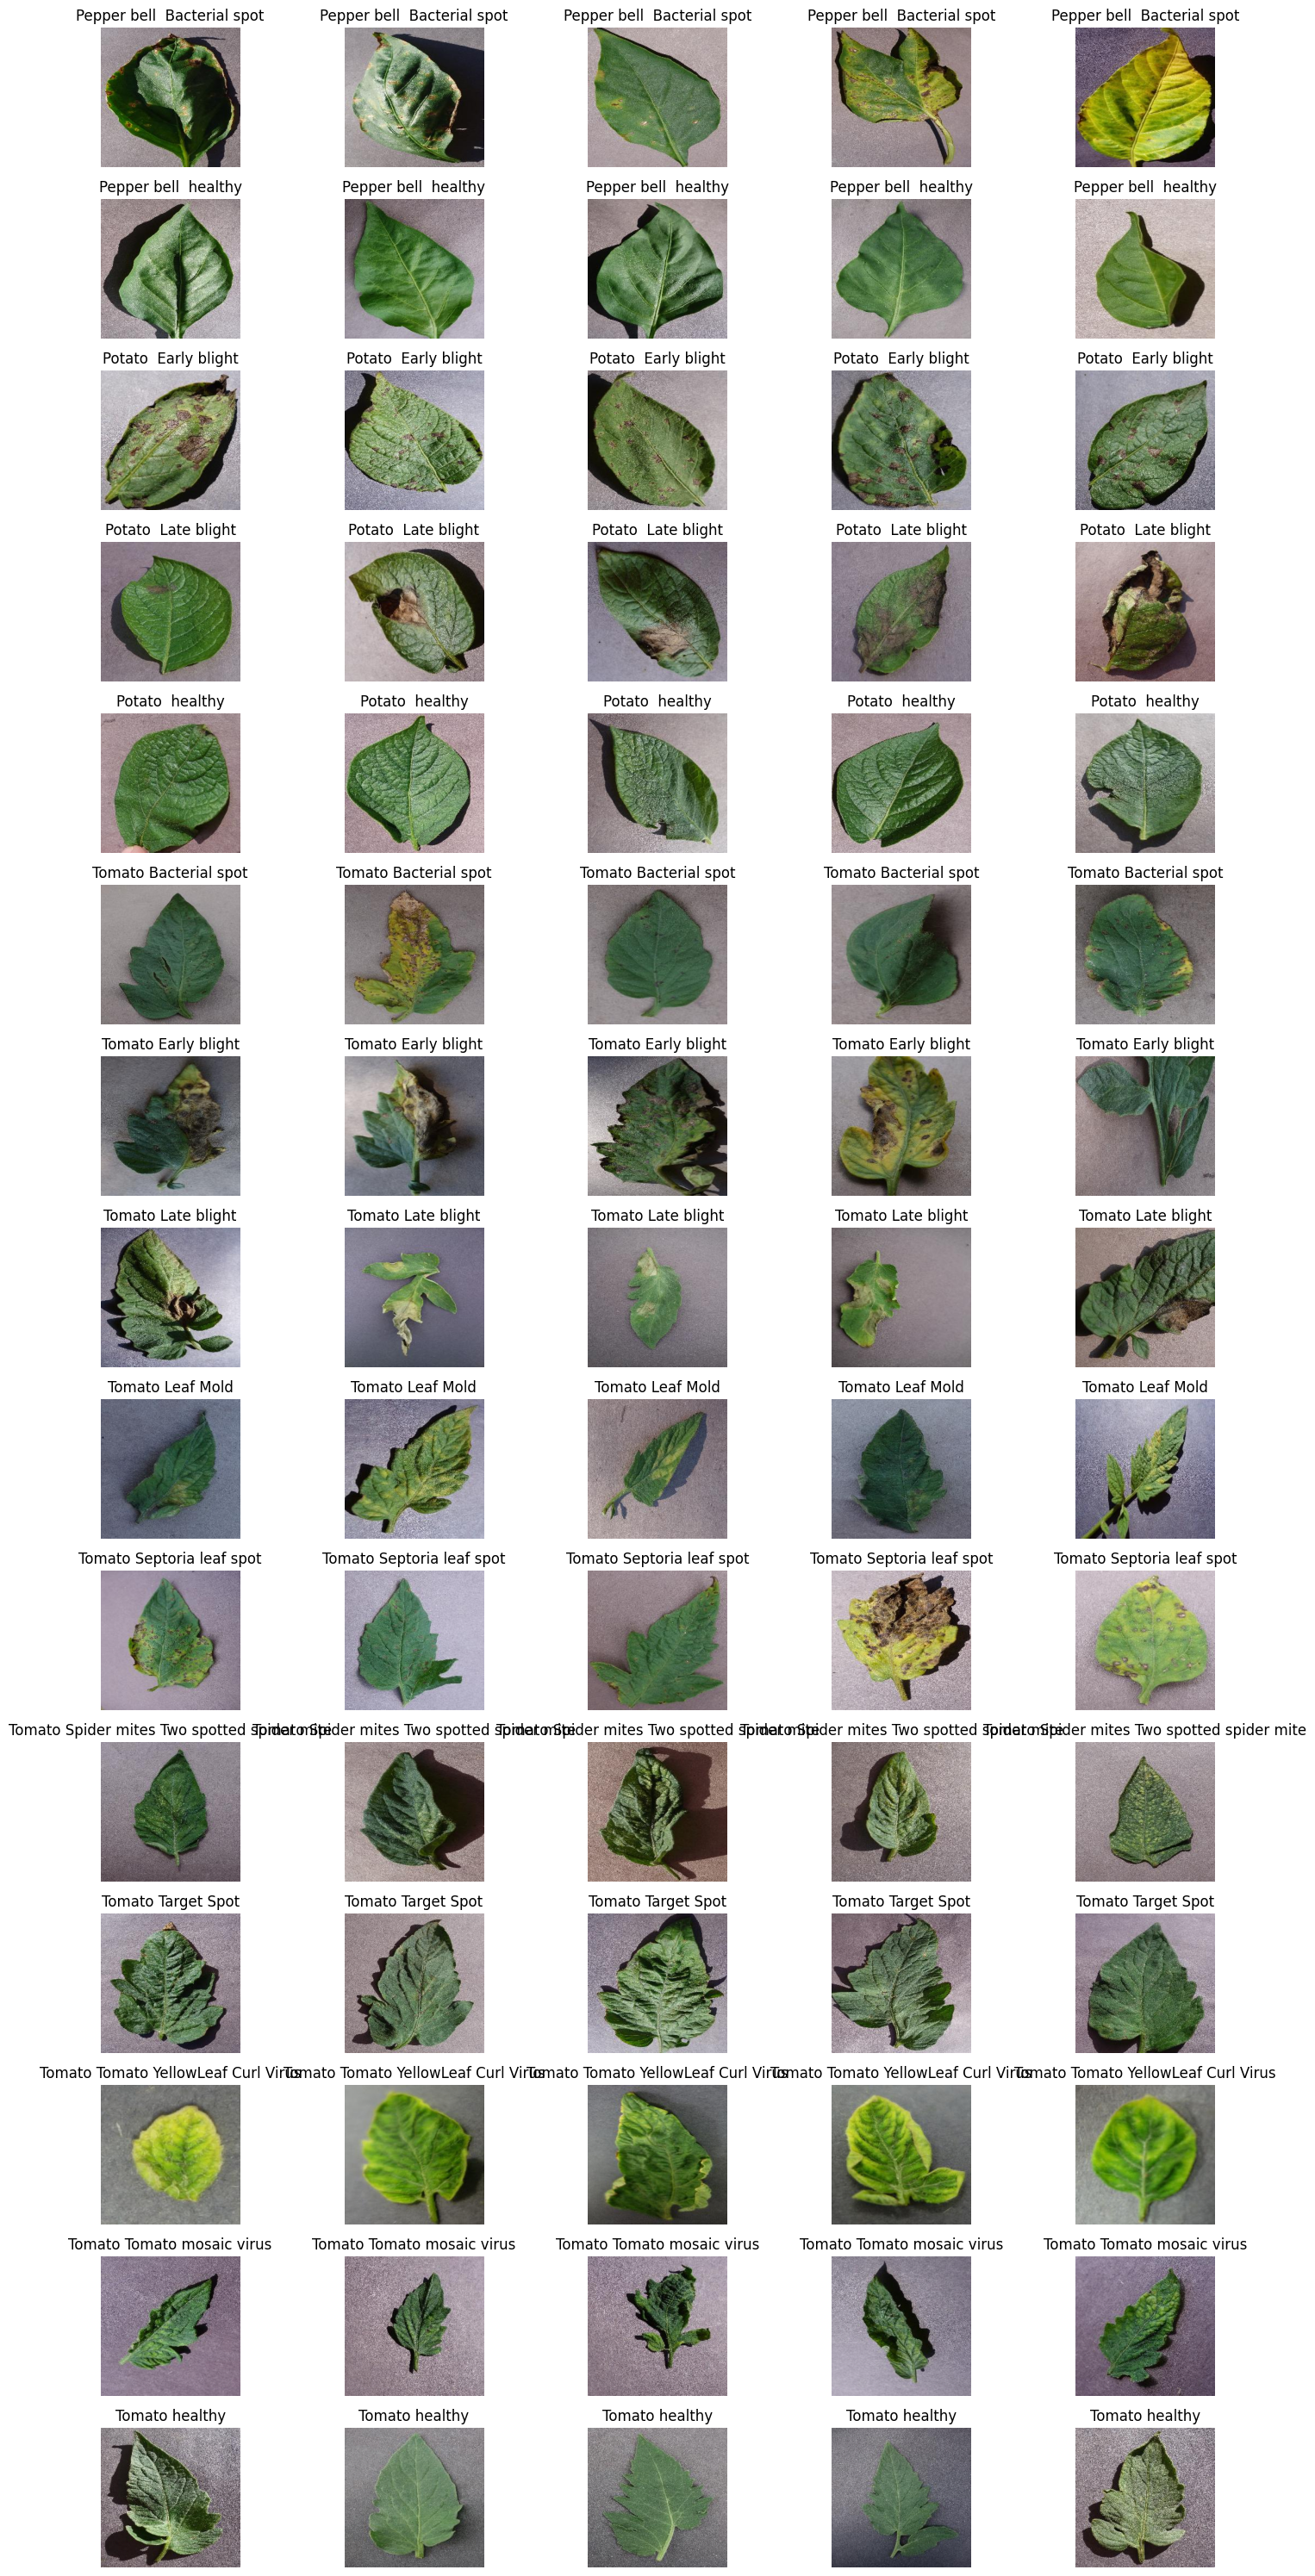

In [20]:
show_sample_images()

### **RGB Color Distribution for a random image**

In [21]:
def plot_rgb_histogram(image_path):
    """Plots RGB color histogram for a given image."""
    image = cv2.imread(image_path)
    colors = ('r', 'g', 'b')
    plt.figure(figsize=(7, 4))
    for i, color in enumerate(colors):
        hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        plt.plot(hist, color=color)
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.title("RGB Color Distribution")
    plt.show()

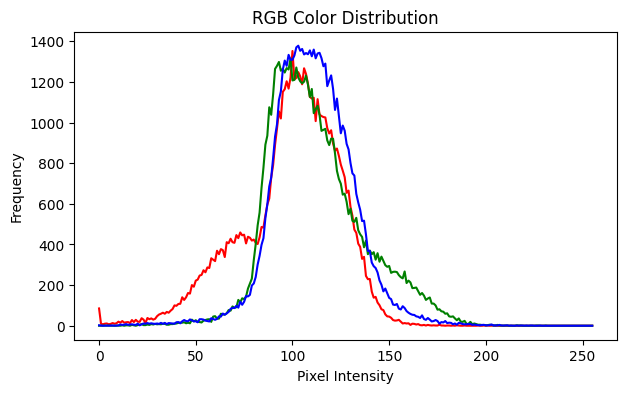

In [22]:
random_class = np.random.choice(class_names)
random_img_path = os.path.join(DATASET_PATH, random_class, np.random.choice(os.listdir(os.path.join(DATASET_PATH, random_class))))
plot_rgb_histogram(random_img_path)

### **Analyzing pixel distribution**

The image represents the **pixel intensity distribution** of an image dataset across the **Red, Green, and Blue (RGB) channels**. 

### Key Observations:
1. **Histogram Representation**:
   - The x-axis represents **mean pixel intensity values** (ranging from 0 to 255).
   - The y-axis represents **frequency** (the number of pixels with a given intensity value).

2. **Color Distribution**:
   - **Red Channel (Red Histogram)**: Peaks around 120–130 intensity.
   - **Green Channel (Green Histogram)**: Has the highest peak, around 125 intensity.
   - **Blue Channel (Blue Histogram)**: More spread out and peaks around 110–120 intensity.

3. **Shape and Spread**:
   - The **green channel has the highest peak**, indicating that green tones are dominant in the dataset.
   - The **blue channel is more spread out** compared to red and green, meaning blue pixels have a wider range of intensities.

### Possible Interpretations:
- The dataset might be **plant or natural images** since green is dominant.
- The image distribution is **right-skewed**, meaning **darker pixels (low intensity) are less frequent** than mid-range intensities.
- This histogram is useful for **image preprocessing**, such as normalization, contrast adjustment, or data augmentation in deep learning tasks.

In [ ]:
def analyze_pixel_distribution():
    """
    Computes the average pixel intensity distribution for R, G, and B channels 
    across all images in the dataset.
    
    Returns:
    None (Displays a histogram of pixel intensities)
    """
    red_values, green_values, blue_values = [], [], []

    for class_name in class_names:
        class_path = os.path.join(DATASET_PATH, class_name)
        
        # Load all image files in the class directory
        img_files = glob.glob(os.path.join(class_path, "*.*"))
        img_files = [f for f in img_files if f.lower().endswith((".jpg", ".jpeg", ".png"))]

        for img_file in img_files:
            img = Image.open(img_file).convert("RGB")  # Ensure RGB mode
            img_array = np.array(img)  # Convert to NumPy array
            
            # Compute mean values per channel
            red_values.append(np.mean(img_array[:, :, 0]))   # Red Channel
            green_values.append(np.mean(img_array[:, :, 1])) # Green Channel
            blue_values.append(np.mean(img_array[:, :, 2]))  # Blue Channel

    # Convert lists to NumPy arrays
    red_values = np.array(red_values)
    green_values = np.array(green_values)
    blue_values = np.array(blue_values)

    # Plot the histogram of pixel intensities
    plt.figure(figsize=(8, 5))
    plt.hist(red_values, bins=50, alpha=0.6, color='red', label='Red Channel')
    plt.hist(green_values, bins=50, alpha=0.6, color='green', label='Green Channel')
    plt.hist(blue_values, bins=50, alpha=0.6, color='blue', label='Blue Channel')

    plt.xlabel("Mean Pixel Intensity")
    plt.ylabel("Frequency")
    plt.title("Pixel Intensity Distribution (R, G, B)")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# Call function
analyze_pixel_distribution()

**T-SNE ASSOCIATION**

In [ ]:
# Load Pretrained Model (Feature Extractor)
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

# Load Images and Extract Features
features = []
labels = []
class_mapping = {class_name: idx for idx, class_name in enumerate(class_names)}

for class_name in tqdm(class_names, desc="Extracting Features"):
    class_path = os.path.join(DATASET_PATH, class_name)
    img_files = glob.glob(os.path.join(class_path, "*.JPG"))[:50]  # Limit per class for speed

    for img_file in img_files:
        img = image.load_img(img_file, target_size=(224, 224))  # Resize image
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array = preprocess_input(img_array)  # Normalize for ResNet50

        feature_vector = feature_extractor.predict(img_array).flatten()  # Extract features
        features.append(feature_vector)
        labels.append(class_mapping[class_name])

# Convert to NumPy arrays
features = np.array(features)
labels = np.array(labels)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(features)

# Plot t-SNE
plt.figure(figsize=(10, 6))
palette = sns.color_palette("hsv", len(class_names))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=[class_names[i] for i in labels], palette=palette, legend="full", alpha=0.7)
plt.title("t-SNE Visualization of Image Features")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
plt.show()


The image is a **t-SNE visualization of image features**, where each point represents an image, and similar images are clustered together in a lower-dimensional space.

### **Key Observations:**
1. **t-SNE Components:**
   - The x-axis and y-axis represent **t-SNE Component 1 and Component 2**, which are low-dimensional representations of high-dimensional image features.

2. **Clustering of Classes:**
   - Different colors represent different categories of plant diseases and healthy crops.
   - Labels in the legend indicate classes such as **Pepper Bell Bacterial Spot, Potato Early Blight, Tomato Leaf Mold, etc.**
   - Similar diseases and plant types tend to be **closer together**, meaning they share similar visual features.

3. **Clear Separation for Some Classes:**
   - Some clusters, like **Tomato Mosaic Virus (pink)** and **Tomato YellowLeaf Curl Virus (purple)**, seem to be well-separated, indicating distinct feature differences.
   - Others, like **Tomato Early Blight (cyan)** and **Tomato Late Blight (blue)**, seem to have some overlap, meaning they might share similar visual characteristics.
